In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import time



In [2]:
# 1. Data Collection
# Load dataset (downloaded from Kaggle)
data = pd.read_csv("creditcard.csv")
print(data.head())



   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [3]:
# 2. Data Preprocessing
X = data.drop("Class", axis=1)
y = data["Class"]



In [4]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print("Before SMOTE:", y.value_counts())
print("After SMOTE:", y_resampled.value_counts())



Before SMOTE: 0    284315
1       492
Name: Class, dtype: int64
After SMOTE: 0    284315
1    284315
Name: Class, dtype: int64


In [5]:
# Feature Scaling (SVM requires normalization)
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)



In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_scaled, y_resampled, test_size=0.2, random_state=42
)



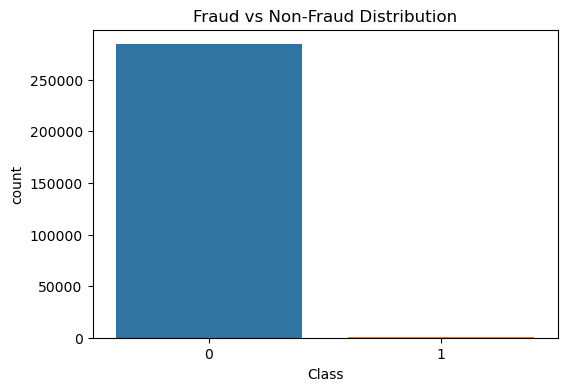

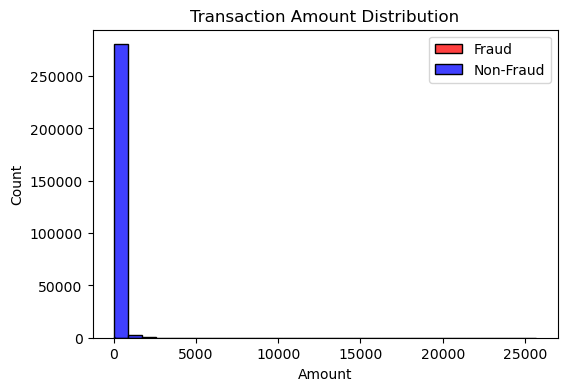

In [7]:
# 3. Exploratory Data Analysis (EDA)
plt.figure(figsize=(6,4))
sns.countplot(data=data, x="Class")
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(data[data['Class']==1]['Amount'], bins=30, color='red', label='Fraud')
sns.histplot(data[data['Class']==0]['Amount'], bins=30, color='blue', label='Non-Fraud')
plt.legend()
plt.title("Transaction Amount Distribution")
plt.show()



In [ ]:
# 4. Model Building (SVM)
# Linear SVM
svm_linear = SVC(kernel="linear", class_weight="balanced")
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)



In [ ]:
# RBF Kernel SVM with hyperparameter tuning
param_grid = {"C": [0.1, 1, 10], "gamma": ["scale", 0.01, 0.1], "kernel": ["rbf"]}
grid = GridSearchCV(SVC(class_weight="balanced"), param_grid, scoring="recall", cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

best_svm = grid.best_estimator_
y_pred_rbf = best_svm.predict(X_test)



In [ ]:
# 5. Model Evaluation
print("Linear SVM:")
print(classification_report(y_test, y_pred_linear))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_linear))

print("\nRBF Kernel SVM (Best Params):", grid.best_params_)
print(classification_report(y_test, y_pred_rbf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rbf))



In [ ]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_svm.decision_function(X_test))
plt.plot(fpr, tpr, label="RBF SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()





In [ ]:
# 6. Real-Time Simulation
print("\n--- Real-Time Fraud Detection Simulation ---")
def simulate_real_time(model, scaler, stream_data, threshold=0.5):
    for i, row in stream_data.iterrows():
        X_new = scaler.transform([row.drop("Class").values])
        pred = model.predict(X_new)[0]
        if pred == 1:
            print(f"[ALERT ] Fraudulent transaction detected at index {i} | Amount: {row['Amount']}")
        time.sleep(0.1)  # simulate streaming delay

In [ ]:
# Take a small sample for simulation
stream_sample = data.sample(20, random_state=42)
simulate_real_time(best_svm, scaler, stream_sample)



In [ ]:
# 7. Insights & Business Value
fraud_cases = data[data["Class"] == 1]
print("\nFraud Insights:")
print("Average Fraud Amount:", fraud_cases["Amount"].mean())
print("Most Fraudulent Time Range (approx.):", fraud_cases["Time"].mode()[0])

print("\nRecommendations:")
print("- Flag transactions above a suspicious amount threshold.")
print("- Monitor high-risk time windows.")
print("- Add additional verification for unusual frequency or IP/location mismatches.")